In [9]:
# Cell 1: Import libraries and set up environment
# This cell imports all necessary libraries for data handling, image processing, and model building.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [10]:
# Cell 2: Load dataset metadata and prepare file paths
# This cell loads the CSV annotation files and creates a simplified DataFrame with file names and labels.
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
train_labels_csv = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_csv = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

labels_df = pd.read_csv(train_labels_csv)
class_info_df = pd.read_csv(class_info_csv)

merged_df = pd.merge(labels_df, class_info_df, on="patientId")
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
labels_simple['patientId'] = labels_simple['patientId'].astype(str) + ".dcm"

print("✅ Metadata loaded successfully!")
print(f"Total records: {len(labels_simple)}")


✅ Metadata loaded successfully!
Total records: 26684


In [11]:
# Cell 3: Define image loading and preprocessing function
# This cell defines a function to read a DICOM file, normalize its pixel values, and resize the image.
def load_preprocess_dicom(dicom_path, img_size=(128, 128)):
    # Read the DICOM file and extract the image array
    dicom_data = pydicom.dcmread(dicom_path)
    img_array = dicom_data.pixel_array.astype(np.float32)
    # Normalize the image to the [0, 1] range
    img_norm = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-10)
    # Resize the image to the target dimensions
    img_resized = cv2.resize(img_norm, img_size)
    # Expand dimensions to add the channel axis (for grayscale images)
    img_resized = np.expand_dims(img_resized, axis=-1)
    return img_resized

# Test the function on a sample image (optional)
sample_image_path = os.path.join(dataset_path, "stage_2_train_images", labels_simple.iloc[0]['patientId'])
sample_img = load_preprocess_dicom(sample_image_path)
print("✅ Sample image loaded and preprocessed. Shape:", sample_img.shape)


✅ Sample image loaded and preprocessed. Shape: (128, 128, 1)


In [12]:
# Cell 4: Prepare data generators for training and validation
# This cell splits the dataset into training and validation sets and creates a custom data generator.
from sklearn.model_selection import train_test_split

# Split the DataFrame into training and validation sets using stratification on Target
train_df, val_df = train_test_split(labels_simple, test_size=0.2, random_state=42, stratify=labels_simple['Target'])
print("Train samples:", len(train_df), "Validation samples:", len(val_df))

def data_generator(df, batch_size=16, img_size=(128, 128)):
    def gen():
        for _, row in df.iterrows():
            patient_id = row['patientId']
            # Convert label to binary (1 for Pneumonia, 0 for Normal)
            label = 1 if row['Target'] == 'Pneumonia' else 0
            dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
            img = load_preprocess_dicom(dicom_path, img_size)
            yield img, label
    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32),
        output_shapes=((img_size[0], img_size[1], 1), ())
    )
    # Shuffle and batch the dataset (no repeat since we calculate steps_per_epoch)
    ds = ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

batch_size = 16
train_ds = data_generator(train_df, batch_size=batch_size)
val_ds = data_generator(val_df, batch_size=batch_size)


Train samples: 21347 Validation samples: 5337


In [14]:
# Cell 5: Build a basic CNN model for pneumonia classification
# This cell defines a simple CNN architecture using an Input layer for binary classification of chest X-rays.
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(128, 128, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Cell 6: Train the CNN model using data generators with class weighting
# This cell trains the model on the training set and validates on the validation set, handling class imbalance with class weights.
epochs = 5  # You may increase the number of epochs for better performance

# Calculate steps per epoch based on the training set size
steps_per_epoch = int(np.ceil(len(train_df) / batch_size))

# Calculate class weights using sklearn's class_weight utility
from sklearn.utils import class_weight

# Convert the training labels to binary (0 for Normal, 1 for Pneumonia)
y_train = train_df['Target'].apply(lambda x: 1 if x == 'Pneumonia' else 0)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(weights)}
print("Class weights:", class_weights)

# Train the model with the computed class weights
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    class_weight=class_weights
)


Class weights: {0: 0.6454314567333858, 1: 2.219022869022869}
Epoch 1/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 357s 255ms/step - accuracy: 0.6768 - loss: 0.6110 - val_accuracy: 0.7120 - val_loss: 0.5856
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1335/1335 ━━━━━━━━━━━━━━━━━━━━ 68s 51ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7120 - val_loss: 0.5856
Epoch 3/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 339s 245ms/step - accuracy: 0.7266 - loss: 0.5584 - val_accuracy: 0.7216 - val_loss: 0.5624
Epoch 4/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 67s 50ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7216 - val_loss: 0.5624
Epoch 5/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 334s 240ms/step - accuracy: 0.7337 - loss: 0.5446 - val_accuracy: 0.7750 - val_loss: 0.4889


334/334 ━━━━━━━━━━━━━━━━━━━━ 64s 153ms/step - accuracy: 0.7752 - loss: 0.4848
Validation Loss: 0.48894602060317993
Validation Accuracy: 0.7749671936035156


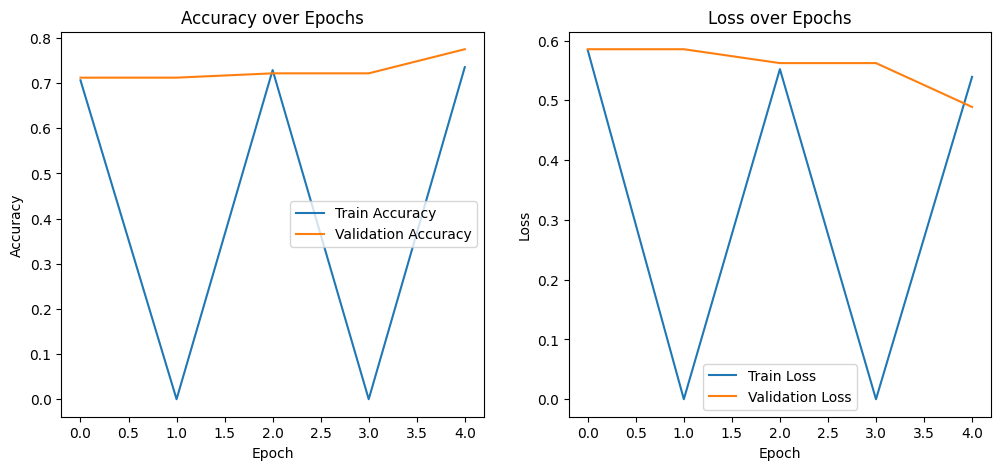

In [16]:
# Cell 7: Evaluate the model and plot training history
# This cell evaluates the trained model on the validation set and visualizes the accuracy and loss curves.
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training history for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Evalutaion metrices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

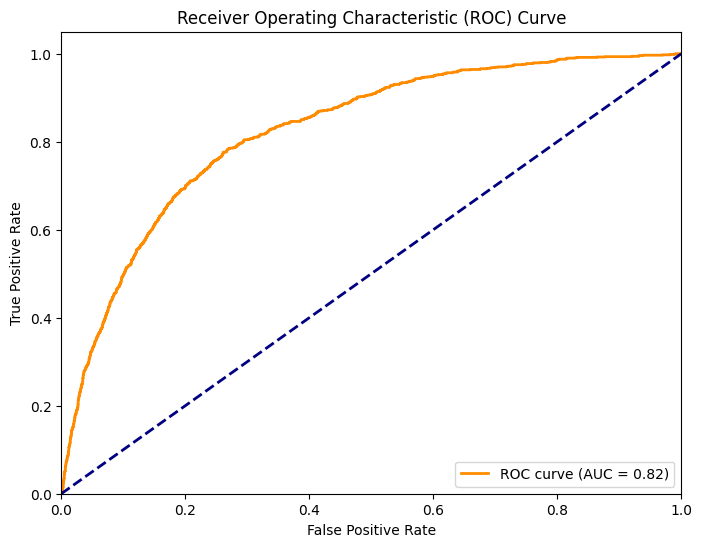

In [17]:
# Cell 8: Evaluate model performance using multiple metrics
# This cell computes accuracy, precision, recall, confusion matrix, F1-score, and plots the ROC curve along with AUC.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, f1_score, roc_curve, auc
)

# Collect true labels and model predictions from the validation dataset
y_true = []
y_pred = []
y_scores = []  # For ROC curve: the predicted probabilities

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    # Convert probabilities to binary predictions (threshold of 0.5)
    y_pred.extend((preds > 0.5).astype("int32").flatten())
    y_scores.extend(preds.flatten())

# Compute evaluation metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Print the evaluation metrics
print("Accuracy: {:.2f}%".format(acc * 100))
print("Precision: {:.2f}".format(prec))
print("Recall (Sensitivity): {:.2f}".format(rec))
print("F1-Score: {:.2f}".format(f1))
print("Confusion Matrix:\n", cm)
print("AUC: {:.2f}".format(roc_auc))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Improving
